## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

from itertools import chain
from skimage import io

from sklearn.model_selection import train_test_split
from random import sample 
import scipy

from keras.preprocessing.image import ImageDataGenerator

from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50 
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.

Using TensorFlow backend.


In [2]:
!ls /data/

ARXIV_V5_CHESTXRAY.pdf	images_002  images_007	images_012
BBox_List_2017.csv	images_003  images_008	LOG_CHESTXRAY.pdf
Data_Entry_2017.csv	images_004  images_009	README_CHESTXRAY.pdf
FAQ_CHESTXRAY.pdf	images_005  images_010	test_list.txt
images_001		images_006  images_011	train_val_list.txt


In [3]:
image_paths = {os.path.basename(x): x for x in glob(os.path.join('/data','images*', '*', '*.png'))}
image_paths

{'00019124_042.png': '/data/images_009/images/00019124_042.png',
 '00019576_024.png': '/data/images_009/images/00019576_024.png',
 '00019545_003.png': '/data/images_009/images/00019545_003.png',
 '00020065_000.png': '/data/images_009/images/00020065_000.png',
 '00020356_000.png': '/data/images_009/images/00020356_000.png',
 '00019962_003.png': '/data/images_009/images/00019962_003.png',
 '00018936_005.png': '/data/images_009/images/00018936_005.png',
 '00018562_007.png': '/data/images_009/images/00018562_007.png',
 '00020326_026.png': '/data/images_009/images/00020326_026.png',
 '00018704_000.png': '/data/images_009/images/00018704_000.png',
 '00020383_004.png': '/data/images_009/images/00020383_004.png',
 '00019576_021.png': '/data/images_009/images/00019576_021.png',
 '00019742_008.png': '/data/images_009/images/00019742_008.png',
 '00020326_018.png': '/data/images_009/images/00020326_018.png',
 '00020187_002.png': '/data/images_009/images/00020187_002.png',
 '00019847_004.png': '/da

## Do some early processing of your metadata for easier model training:

In [4]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df_ori
all_xray_df_ori = pd.read_csv('/data/Data_Entry_2017.csv')

all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}

print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df_ori.shape[0])

all_xray_df_ori['path'] = all_xray_df_ori['Image Index'].map(all_image_paths.get)

all_xray_df_ori.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
74331,00018253_014.png,Effusion|Infiltration,14,18253,70,F,PA,2492,2743,0.143000,0.143000,NaN,/data/images_008/images/00018253_014.png
109916,00029903_007.png,Pneumothorax,7,29903,26,M,PA,2021,2021,0.194311,0.194311,NaN,/data/images_012/images/00029903_007.png
95287,00024999_000.png,No Finding,0,24999,22,F,PA,2544,3056,0.139000,0.139000,NaN,/data/images_011/images/00024999_000.png


In [5]:
# drop the last column since it only has null values
# create a copy of the dataframe to preserve the original data for future reference
all_xray_df = all_xray_df_ori.copy()
all_xray_df = all_xray_df.dropna(axis=1)

# rename column names to match sample_df.
all_xray_df = all_xray_df.rename(columns = {'OriginalImage[Width':'OriginalImageWidth',
                              'Height]':'OriginalImageHeight', 
                              'OriginalImagePixelSpacing[x':'OriginalImagePixelSpacing_x',
                              'y]':'OriginalImagePixelSpacing_y'
                             })
all_xray_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,/data/images_001/images/00000001_000.png
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,/data/images_001/images/00000001_001.png
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,/data/images_001/images/00000001_002.png
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,/data/images_001/images/00000002_000.png
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,/data/images_001/images/00000003_000.png


In [6]:
## Here I'm going to split up my "Finding Labels" column so that I have one column per disease in my dataframe,
# with a binary flag (0 for Yes; 1 for No). This makes EDA a lot easier! 
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]

print('All Labels ({}): {}'.format(len(all_labels), all_labels))

for i in all_labels:
    if len(i) > 1: # leave out empty labels
        all_xray_df[i] = all_xray_df['Finding Labels'].map(lambda x: 1.0 if i in x else 0)

all_xray_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
21622,00005750_022.png,No Finding,22,5750,24,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
108996,00029596_018.png,Atelectasis|Effusion,18,29596,34,F,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
94194,00023991_000.png,Fibrosis|Pleural_Thickening,0,23991,55,F,PA,3056,2544,0.139,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [7]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification
all_xray_df['pneumonia_class'] = all_xray_df['Pneumonia'].map(lambda x: int(x))
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
68818,00016976_000.png,Cardiomegaly,0,16976,51,F,PA,2992,2649,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
45343,00011622_005.png,No Finding,5,11622,49,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
47657,00012089_003.png,No Finding,3,12089,40,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0


In [8]:
# calculate % of pneumonia cases in the dataset
np.sum(all_xray_df['pneumonia_class'])/len(all_xray_df)*100

1.2763110952550838

## Create your training and testing data:

In [9]:
def create_splits(df, col):
    # col = 'Pneumonia'
    
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    # Todo
    train_df, val_df = train_test_split(df, 
                                   test_size = 0.2, 
                                   stratify = df[col])
    
    print(train_df[col].sum()/len(train_df))
    print(val_df[col].sum()/len(val_df))
    
    # our train_test_split made sure that we had the same proportions of pneumonia in both sets!
    # But.... we know that we want our model to be trained on a set that has equal proportions of pneumonia
    # and non-pneumonia, so we're going to have to throw away some data
    
    # train
    # We randomly chose a set of non-Pneumonia images using the sample() function that was the same length 
    # as the number of true Pneumonia cases we had, and then we threw out the rest of the non-Pneumonia cases 
    # so that our training dataset is balanced 50-50.
    pneumonia_idx = train_df[train_df[col]==1].index.tolist()
    nonpneumonia_idx = train_df[train_df[col]==0].index.tolist()

    nonpneumonia_sample = sample(nonpneumonia_idx, len(pneumonia_idx))
    train_df = train_df.loc[pneumonia_idx + nonpneumonia_sample]
    
    print(train_df[col].sum()/len(train_df))

    # validation
    # we want to make the balance in our validation set more like 20-80 since our exercise told us that 
    # the prevalence of Pneumothorax in this clinical situation is about 20%
    pneumonia_idx = val_df[val_df[col]==1].index.tolist()
    nonpneumonia_idx = val_df[val_df[col]==0].index.tolist()

    # The following code pulls a random sample of non-pneumonia data that's 4 times as big as the pneumonia sample.
    nonpneumonia_sample = sample(nonpneumonia_idx, 4*len(pneumonia_idx))
    val_df = val_df.loc[pneumonia_idx + nonpneumonia_sample]
    
    print(val_df[col].sum()/len(val_df))
    
    return train_df, val_df

In [10]:
train_df, val_df = create_splits(all_xray_df, 'Pneumonia')

0.012765340706386016
0.012754191937210132
0.5
0.2


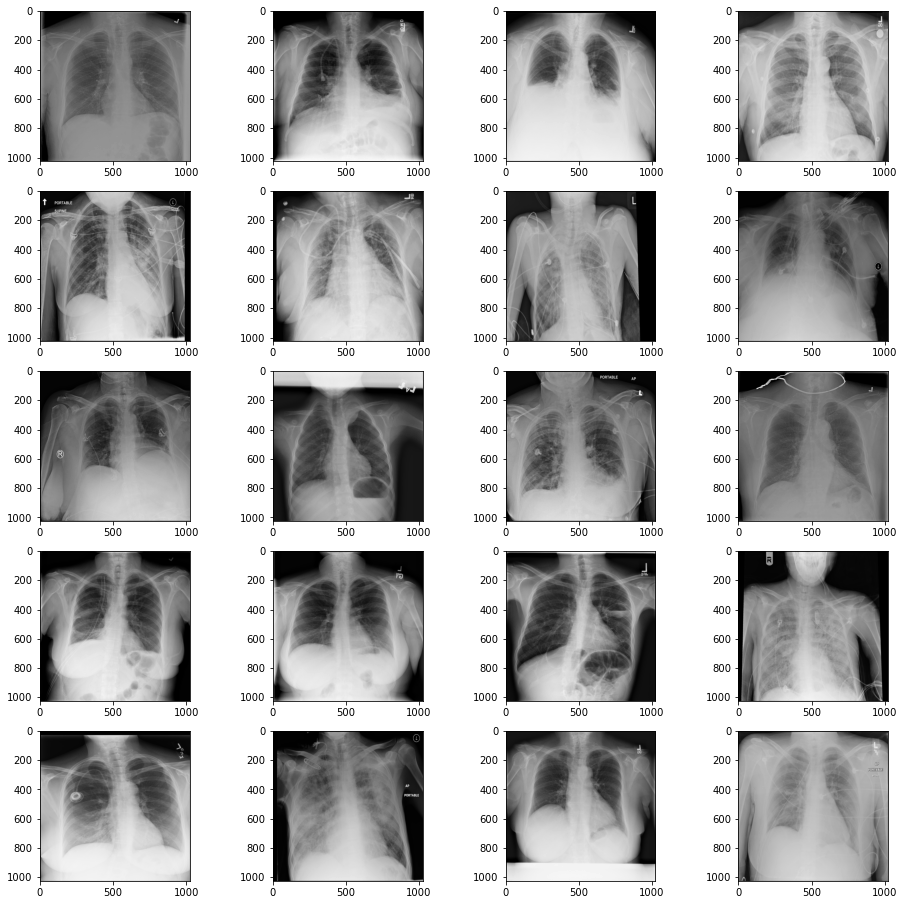

In [11]:
# Create a figure with subplots and has a maximum axis: m-axis
fig, m_axs = plt.subplots(5,4, figsize = (16, 16))

# Return a copy of the array collapsed into one dimension.
m_axs = m_axs.flatten()
imgs = train_df.path
ind=0

for img, ax in zip(imgs, m_axs):
    img = io.imread(img)
    ax.imshow(img,cmap='gray')
    # ax.set_title(train_df.iloc[ind]['pneumonia_class'])
    ind=ind+1

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [12]:
def my_image_augmentation():
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    # Todo
    '''
    horizontal_flip and vertical_flip should be set to True/False
    height_shift_range and width_shift_range should be between 0 and 1
    rotation_range can be between 0 and 180
    shear_range can be between 0 and 1
    zoom_range can be between 0 and 1
    '''
    my_idg = ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.1, 
                              width_shift_range=0.1, 
                              rotation_range=15, 
                              shear_range = 0.1,
                              zoom_range=0.1)
    
    return my_idg


def make_train_gen(train_data, IMG_SIZE):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
    # Todo
    # create column for image_path    
    image_paths = {os.path.basename(x): x for x in glob(os.path.join('/data','images*', '*', '*.png'))}
    train_data['image_path'] = train_data['Image Index'].apply(lambda x: image_paths[x])
    
    # this line (convert to string) is added to pacify TypeError: If class_mode="binary", y_col="pneumonia_class" column values must be strings.
    train_data['pneumonia_class'] = train_data['pneumonia_class'].astype(str)
    
    my_train_idg = my_image_augmentation()
    
    train_gen = my_train_idg.flow_from_dataframe(dataframe=train_data,  
                                                 directory=None, 
                                                 x_col = 'image_path',  
                                                 y_col ='pneumonia_class', 
                                                 class_mode = 'binary',  
                                                 target_size = IMG_SIZE,      
                                                 batch_size = 64     
                                                )
    return train_gen


def make_val_gen(val_data, IMG_SIZE):
    
    # Todo
    image_paths = {os.path.basename(x): x for x in glob(os.path.join('/data','images*', '*', '*.png'))}

    val_data['image_path'] = val_data['Image Index'].apply(lambda x: image_paths[x])
    
    val_data['pneumonia_class'] = val_data['pneumonia_class'].astype(str)
    
    my_val_idg = my_image_augmentation()
    
    val_gen = my_val_idg.flow_from_dataframe(dataframe=val_data,  
                                                 directory=None, 
                                                 x_col = 'image_path',  
                                                 y_col ='pneumonia_class', 
                                                 class_mode = 'binary',  
                                                 target_size = IMG_SIZE,      
                                                 batch_size = 64     
                                                )
    return val_gen

In [13]:
## you can choose an image size to resize your images to during augmentation, which comes in handy later when you
## want to do deep learning using a pre-trained CNN that has a specified size input layer
IMG_SIZE = (224, 224) 

train_gen = make_train_gen(train_df, IMG_SIZE)
val_gen = make_val_gen(val_df, IMG_SIZE)

Found 2290 validated image filenames belonging to 2 classes.
Found 1430 validated image filenames belonging to 2 classes.


In [14]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()

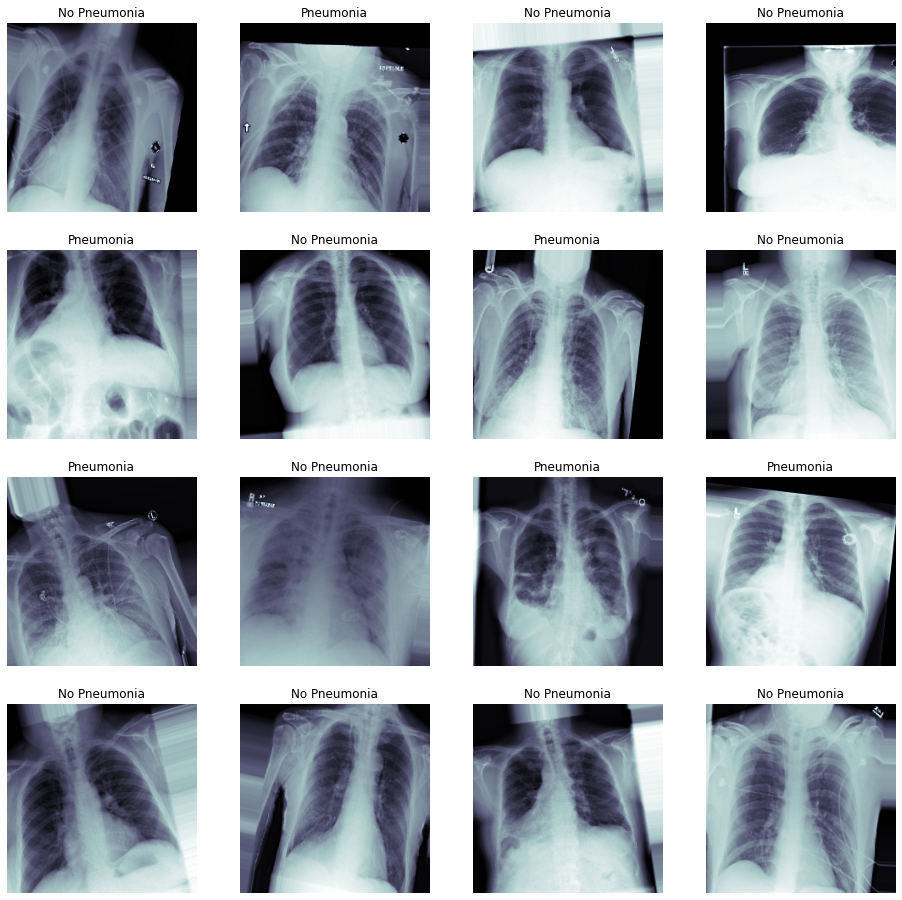

In [15]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Model building: 

Use a pre-trained network downloaded from Keras for fine-tuning

In [16]:
def load_pretrained_model(vargs):
    # We'll load in VGG16 with pre-trained ImageNet weights:
    model = VGG16(include_top=True, weights='imagenet')
    model.summary()
    transfer_layer = model.get_layer('block5_pool')
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    return vgg_model

vgg_model = load_pretrained_model('imagenet')

553467904/553467096 [==============================] - 7s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

# MODEL 1

In [17]:
def build_my_model1(vargs):
    
    # my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    # Todo
    new_model = Sequential()

    # Add the convolutional part of the VGG16 model from above.
    new_model.add(vgg_model)

    # Flatten the output of the VGG16 model because it is from a
    # convolutional layer.
    new_model.add(Flatten())

    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    new_model.add(Dense(1, activation='sigmoid'))
    
    ## Set our optimizer, loss function, and learning rate
    optimizer = Adam(lr=1e-4)
    loss = 'binary_crossentropy'
    metrics = ['binary_accuracy']

    new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return new_model


# freeze some layers in VGG16
for layer in vgg_model.layers[0:17]:
    layer.trainable = False

#     for layer in vgg_model.layers:
#         print(layer.name, layer.trainable)

## Run a few epochs to see how they do:
my_model = build_my_model1(vgg_model)

my_model.fit_generator(train_gen, 
                       validation_data = (valX, valY), 
                       epochs = 5)

## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

Epoch 1/5
36/36 [==============================] - 137s 4s/step - loss: 0.6852 - binary_accuracy: 0.5703 - val_loss: 0.6497 - val_binary_accuracy: 0.5938
Epoch 2/5
36/36 [==============================] - 185s 5s/step - loss: 0.6590 - binary_accuracy: 0.6148 - val_loss: 0.6905 - val_binary_accuracy: 0.5781
Epoch 3/5
36/36 [==============================] - 210s 6s/step - loss: 0.6500 - binary_accuracy: 0.6288 - val_loss: 0.6592 - val_binary_accuracy: 0.5938
Epoch 4/5
36/36 [==============================] - 172s 5s/step - loss: 0.6484 - binary_accuracy: 0.6271 - val_loss: 0.7381 - val_binary_accuracy: 0.4844
Epoch 5/5
36/36 [==============================] - 138s 4s/step - loss: 0.6381 - binary_accuracy: 0.6493 - val_loss: 0.5878 - val_binary_accuracy: 0.6719


# MODEL 2

In [21]:
# add a few more dense layers
def build_my_model2(vargs):
    
    # my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    # Todo
    new_model = Sequential()

    # Add the convolutional part of the VGG16 model from above.
    new_model.add(vgg_model)

    # Flatten the output of the VGG16 model because it is from a
    # convolutional layer.
    new_model.add(Flatten())

    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    new_model.add(Dense(1024, activation='relu'))

    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    new_model.add(Dense(512, activation='relu'))

    # Add a dense (aka. fully-connected) layer.
    # Change the activation function to sigmoid 
    # so output of the last layer is in the range of [0,1] 
    new_model.add(Dense(1, activation='sigmoid'))

    ## Set our optimizer, loss function, and learning rate
    optimizer = Adam(lr=1e-4)
    loss = 'binary_crossentropy'
    metrics = ['binary_accuracy']

    new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return new_model


# freeze some layers in VGG16
for layer in vgg_model.layers[0:17]:
    layer.trainable = False

## Just run a single epoch to see how it does:
my_model2 = build_my_model2(vgg_model)

my_model2.fit_generator(train_gen, 
                       validation_data = (valX, valY), 
                       epochs = 5)

Epoch 1/5
36/36 [==============================] - 185s 5s/step - loss: 0.7223 - binary_accuracy: 0.5507 - val_loss: 0.7083 - val_binary_accuracy: 0.4844
Epoch 2/5
30/36 [========================>.....] - ETA: 34s - loss: 0.6525 - binary_accuracy: 0.6128

/opt/conda/lib/python3.7/site-packages/keras/utils/data_utils.py:616: UserWarning: The input 32 could not be retrieved. It could be because a worker has died.
  UserWarning)


36/36 [==============================] - 315s 9s/step - loss: 0.6564 - binary_accuracy: 0.6087 - val_loss: 0.5877 - val_binary_accuracy: 0.7344
Epoch 3/5
36/36 [==============================] - 214s 6s/step - loss: 0.6476 - binary_accuracy: 0.6301 - val_loss: 0.6617 - val_binary_accuracy: 0.6250
Epoch 4/5
36/36 [==============================] - 106s 3s/step - loss: 0.6457 - binary_accuracy: 0.6323 - val_loss: 0.6793 - val_binary_accuracy: 0.5938
Epoch 5/5
36/36 [==============================] - 87s 2s/step - loss: 0.6258 - binary_accuracy: 0.6559 - val_loss: 0.6883 - val_binary_accuracy: 0.5781


# MODEL 3

In [32]:
# add dropout layer
def build_my_model3(vargs):
    
    # my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    # Todo
    new_model = Sequential()

    # Add the convolutional part of the VGG16 model from above.
    new_model.add(vgg_model)

    # Flatten the output of the VGG16 model because it is from a
    # convolutional layer.
    new_model.add(Flatten())

    # Add a dropout-layer which may prevent overfitting and
    # improve generalization ability to unseen data e.g. the test-set.
    new_model.add(Dropout(0.5))

    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    new_model.add(Dense(1024, activation='relu'))

    # Add a dropout-layer which may prevent overfitting and
    # improve generalization ability to unseen data e.g. the test-set.
    new_model.add(Dropout(0.5))

    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    new_model.add(Dense(512, activation='relu'))

    # Add a dropout-layer which may prevent overfitting and
    # improve generalization ability to unseen data e.g. the test-set.
    new_model.add(Dropout(0.5))

    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    new_model.add(Dense(256, activation='relu'))

    # Add a dense (aka. fully-connected) layer.
    # Change the activation function to sigmoid 
    # so output of the last layer is in the range of [0,1] 
    new_model.add(Dense(1, activation='sigmoid'))

    ## Set our optimizer, loss function, and learning rate
    optimizer = Adam(lr=1e-4)
    loss = 'binary_crossentropy'
    metrics = ['binary_accuracy']

    new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return new_model


# freeze some layers in VGG16
for layer in vgg_model.layers[0:17]:
    layer.trainable = False

## Just run a single epoch to see how it does:
my_model3 = build_my_model3(vgg_model)

my_model3.fit_generator(train_gen, 
                       validation_data = (valX, valY), 
                       epochs = 5)

Epoch 1/5
36/36 [==============================] - 61s 2s/step - loss: 0.6968 - binary_accuracy: 0.5345 - val_loss: 0.6343 - val_binary_accuracy: 0.6094
Epoch 2/5
36/36 [==============================] - 59s 2s/step - loss: 0.6777 - binary_accuracy: 0.5847 - val_loss: 0.6394 - val_binary_accuracy: 0.6406
Epoch 3/5
36/36 [==============================] - 59s 2s/step - loss: 0.6610 - binary_accuracy: 0.6096 - val_loss: 0.6686 - val_binary_accuracy: 0.6094
Epoch 4/5
36/36 [==============================] - 57s 2s/step - loss: 0.6532 - binary_accuracy: 0.6197 - val_loss: 0.6648 - val_binary_accuracy: 0.6094
Epoch 5/5
36/36 [==============================] - 58s 2s/step - loss: 0.6469 - binary_accuracy: 0.6393 - val_loss: 0.7237 - val_binary_accuracy: 0.5312


# MODEL 4

In [ ]:
def build_my_model4(vargs):
    
    
    
    
    return new_model

In [33]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo
CHOOSE_METRIC_TO_MONITOR_FOR_PERFORMANCE = 'val_acc'
CHOOSE_MIN_OR_MAX_FOR_YOUR_METRIC = 'max'
weight_path3= r"/data/{}_my_model3.best.hdf5".format('xray_class')

checkpoint3 = ModelCheckpoint(weight_path3, 
                             monitor= CHOOSE_METRIC_TO_MONITOR_FOR_PERFORMANCE, 
                             verbose=1, 
                             save_best_only=True, 
                             mode= CHOOSE_MIN_OR_MAX_FOR_YOUR_METRIC, 
                             save_weights_only = True)

early = EarlyStopping(monitor= CHOOSE_METRIC_TO_MONITOR_FOR_PERFORMANCE, #SAME_AS_METRIC_CHOSEN_ABOVE, 
                      mode= CHOOSE_MIN_OR_MAX_FOR_YOUR_METRIC, 
                      patience=10)

callbacks_list3 = [checkpoint3, early]

In [ ]:
model_path = "my_model.json" 
weight_path = "xray_class_model.best.hdf5"
json_file = open(model_path, "r") 
loaded_model_json = json_file.read() 
json_file.close() 
my_model = model_from_json(loaded_model_json) 
my_model.load_weights(weight_path)

### Start training! 

In [19]:
## train your model

# Todo

# history = my_model.fit_generator(train_gen, 
#                           validation_data = (valX, valY), 
#                           epochs = , 
#                           callbacks = callbacks_list)

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [1]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
my_model2.load_weights(weight_path2)
pred_Y = my_model2.predict(valX, batch_size = 32, verbose = True)

In [ ]:
def plot_auc(t_y, p_y):
    
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Pneumonia', auc(fpr, tpr)))
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')
    plt.show()
    
def plot_pr(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    c_ax.plot(recall, precision, label = '%s (AP Score:%0.2f)'  % ('Pneumonia', average_precision_score(t_y,p_y)))
    c_ax.legend()
    c_ax.set_xlabel('Recall')
    c_ax.set_ylabel('Precision')
    
    print('F1 score:', 2*(precision*recall)/(precision+recall))
    
# def calc_f1(prec,recall):
#     return print('F1 score:', 2*(prec*recall)/(prec+recall))
    
def plot_f1(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    f1_scores = []
    thresholds = []
    max_f1 = 0
    best_threshold = None
    for t in np.arange(0.0,1,0.01):        
        y_pred_class = p_y > t
        f1 = f1_score(t_y, y_pred_class)
        if max_f1 < f1:
            max_f1 = f1
            best_threshold = t
        f1_scores.append(f1)
        thresholds.append(t)
    
    c_ax.plot(thresholds, f1_scores,
              label = '%s (Best F1 Score:%0.2f with threshold %.2f)'  % ('Pneumonia', max_f1, best_threshold))
    c_ax.legend()
    c_ax.set_xlabel('threshold')
    c_ax.set_ylabel('f1')

In [ ]:
## plot figures
t_y = valY
p_y = pred_Y

# Todo
plot_auc(t_y, p_y)
plot_pr(t_y, p_y)
# calc_f1(prec,recall)
plot_f1(t_y, p_y)

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [ ]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

# Todo

In [ ]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo

# fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
# i = 0
# for (c_x, c_y, c_ax) in zip(valX[0:100], testY[0:100], m_axs.flatten()):
#     c_ax.imshow(c_x[:,:,0], cmap = 'bone')
#     if c_y == 1: 
#         if pred_Y[i] > YOUR_THRESHOLD:
#             c_ax.set_title('1, 1')
#         else:
#             c_ax.set_title('1, 0')
#     else:
#         if pred_Y[i] > YOUR_THRESHOLD: 
#             c_ax.set_title('0, 1')
#         else:
#             c_ax.set_title('0, 0')
#     c_ax.axis('off')
#     i=i+1

In [ ]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)